## Network Simulation and Modeling

Goal: Given the two airline network models, we wish to simulate network traversals of each airline network:
 
--> A hub and spoke based system

--> A point-to-point based system



In [23]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import gaussian_kde
from scipy.integrate import trapz
from scipy.stats import bernoulli


In [24]:
# extract the edge table 
edge_dataset = pd.read_csv("Database\FINAL_EDGE_TABLE.csv")
on_time_data = pd.read_csv('Database\FINAL_ON_TIME_DATA.csv')

def preprocess_data(df):
    '''
    Goal: Extract new edge attributes and reduce edge data table
    Parameters:
        df (pandas dataframe) input hub-spoke or point to point edge data
    Return:
        edge (pandas dataframe) cleaned output network edge data
    '''
    # create another column to preprocess the data and create new data table attributes
    df['net_profit'] = ( df['revenue'] * 1000 - df['total_operating_expense'] ) * df['Proportion of Seats filled']
    # extract route demand metric
    df['Demand_prop'] = df['passengers'] / df['seats']


    # drop additional columns that we wont need for simulation
    edge = df.filter(['Demand_prop', 'net_profit','Origin_Airport_Code','Destination_Airport_Code','Proportion of Seats filled','CANCELLED','citypair'],axis=1)
    # create a networkx graph from this edge dataset
    G = nx.from_pandas_edgelist(df = edge, source = 'Origin_Airport_Code', target = 'Destination_Airport_Code', 
                               edge_attr = ['CANCELLED', 'net_profit','Proportion of Seats filled','citypair','Demand_prop'])
    # convert graph to a directed graph
    G = G.to_directed()
    return G

p_2_p_Graph = preprocess_data(edge_dataset) 

In [25]:
# Let's check if there are any leafs in the Graph --> this will affect our simulation so we must 
# i.e. there exists many cycles in the graph
print([x for x in p_2_p_Graph.nodes() if p_2_p_Graph.in_degree(x)==0])

print([x for x in p_2_p_Graph.nodes() if p_2_p_Graph.out_degree(x)==0])

color=nx.get_edge_attributes(p_2_p_Graph,'net_profit')
color[('EWR','PHX')]

adj_nodes = list(p_2_p_Graph.neighbors('EWR'))
demand=nx.get_edge_attributes(p_2_p_Graph,'Demand_prop')
node_demand_probs = [demand[i] for i in list(p_2_p_Graph.edges('EWR'))] 
node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
next_node = adj_nodes[next_ind[0]]


[]
[]


In [26]:
cancel_prob=nx.get_edge_attributes(p_2_p_Graph,'CANCELLED')
code = cancel_prob[('PHX','EWR')]
r = bernoulli.rvs(p=code, size=1)[0]
r

0

$Pnet_{adjusted} = (Revenue - Operating Expense) * Proportion of Seats Filled $

In [27]:
# random sampling from KDE distributions
def random_samples(citypair,metric):
    # Generate some example data
    # x ~ vector of data based on the following
    # filter data given citypair key and metric argument 
    fltrd = on_time_data.loc[on_time_data['citypair'] == citypair]
    x = (fltrd[metric].to_list())
    # Compute the KDE
    kde = gaussian_kde(x, bw_method='silverman')
    # Truncate the KDE to have support only over x > 0
    pdf_trunc = lambda x: kde(x) * (x >= 0)
    # Normalize the truncated PDF
    norm = trapz(pdf_trunc(np.linspace(0, np.max(x), 1000)), dx=np.max(x)/999)
    pdf_norm = lambda x: pdf_trunc(x) / norm
    # Define the inverse CDF
    x_vals = np.linspace(0, np.max(x), 1000)
    cdf_vals = np.cumsum(pdf_norm(x_vals)) * np.max(x) / 999
    inv_cdf = lambda y: np.interp(y, cdf_vals, x_vals)
    # Generate random samples using inverse transform sampling
    u = np.random.uniform(size=1)
    sample = inv_cdf(u)
    return sample


# define a function to simulate a flight traversal for a sinl
def simulate_flight_traversal(G, start_node, N):
    '''
    Goal: simulate the flight traversal for a single aircraft starting at a given start airport
    Parameters:
        G: The airline network graph (networkx graph object)
        start_node: (string) the starting airport code
        N: number of traversals (edges) to make in the network
        start_node: the selected starting node for 
    Return:
        total_delay_time_accumlated
        total_cancellations
        total_profit generated by this aircraft  
    '''
    current_node = start_node

    # extract each attribute of the graph as a dict
    profits=nx.get_edge_attributes(G,'net_profit')
    cancel_prob=nx.get_edge_attributes(G,'CANCELLED')
    citypair=nx.get_edge_attributes(G,'citypair')

    total_profits = []
    total_dept_delays = []
    total_arrival_delays = []
    number_of_cancel = 0

    number_of_legs = []

    for i in range(N):
        # get all adjacent nodes of the current node
        adj_nodes = list(G.neighbors(current_node))
        # randomly select a flight route given the transition probability 
        demand=nx.get_edge_attributes(p_2_p_Graph,'Demand_prop')
        node_demand_probs = [demand[i] for i in list(p_2_p_Graph.edges(current_node))] 
        node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
        next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
        next_node = adj_nodes[next_ind[0]]

        # calculate the profit of the flight route
        profit = profits[(current_node,next_node)]
        total_profits.append(profit)
        # extract 
        # randomly simulate a delay time from the distribution
        code = citypair[(current_node,next_node)]
        try:
            dept_delay_time = random_samples(code, 'DEP_DELAY_NEW')[0]
            arr_delay_time = random_samples(code, 'ARR_DELAY_NEW')[0]
        except:
            dept_delay_time = 0
            arr_delay_time = 0

        total_dept_delays.append(dept_delay_time)
        total_arrival_delays.append(arr_delay_time)

        cancel_p = cancel_prob[(current_node,next_node)]
        # returns a bernoulli 0 or 1 value
        r = bernoulli.rvs(p=cancel_p, size=1)[0]
        number_of_cancel += r
        # move to the next node
        current_node = next_node
        number_of_legs.append(i+1)
        # return the profit generated by the flight traversal
    return np.sum(total_profits), np.sum(total_dept_delays), np.sum(total_arrival_delays), number_of_cancel, number_of_legs

## Next step
We repeat the simulate_flight_traversal for each airport as a starting node and compile all sampled attributes for comparison

In [8]:
profits,dept_delays,arrival_delays,cancellations,legs = simulate_flight_traversal(G=p_2_p_Graph, start_node='EWR', N=50)

In [28]:
def get_airports(edge_df):
    routes = edge_dataset['citypair'].to_list()
    routes = [i.split('-') for i in routes]
    airports = set([j for i in routes for j in i])
    return airports

p_2_p_airports = get_airports(edge_dataset)

##### We wish to now simulate the running totals for which we fix N and increment through all airports as the starting node

In [29]:
edge_dataset.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'citypair', 'sum_departures_performed',
       'sum_departures_scheduled', 'passengers', 'seats', 'avg_fuel_price',
       'avg_stock_price', 'total_operating_expense', 'revenue',
       'Aircraft_Unit_Cost ($ millions USD)',
       'Aircraft_Inverse_Age 1/age (1/yrs)', 'Number_of_Cancellations',
       'Proportion of Seats filled', 'Aircraft Age (yrs)',
       'Origin_Airport_Code', 'Destination_Airport_Code',
       'origin_airport_type', 'origin_lat', 'origin_long', 'origin_city',
       'dest_airport_type', 'dest_lat', 'dest_long', 'dest_city',
       'origin_population', 'origin_density', 'dest_population',
       'dest_density', 'DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'CANCELLED',
       'net_profit', 'Demand_prop'],
      dtype='object')

In [49]:
from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec = []
dept_delay_vec = []
arr_delay_vec = []
cancellations_vec = []
p_2_p_airports = [i for i in p_2_p_airports]
for loc in tqdm(p_2_p_airports):
    a,b,c,d,e = simulate_flight_traversal(G=p_2_p_Graph, start_node=loc,N=100)
    profits_vec.append(a)
    dept_delay_vec.append(b)
    arr_delay_vec.append(c)
    cancellations_vec.append(d)

100%|██████████| 85/85 [16:40<00:00, 11.77s/it]


### Visualizations and Results

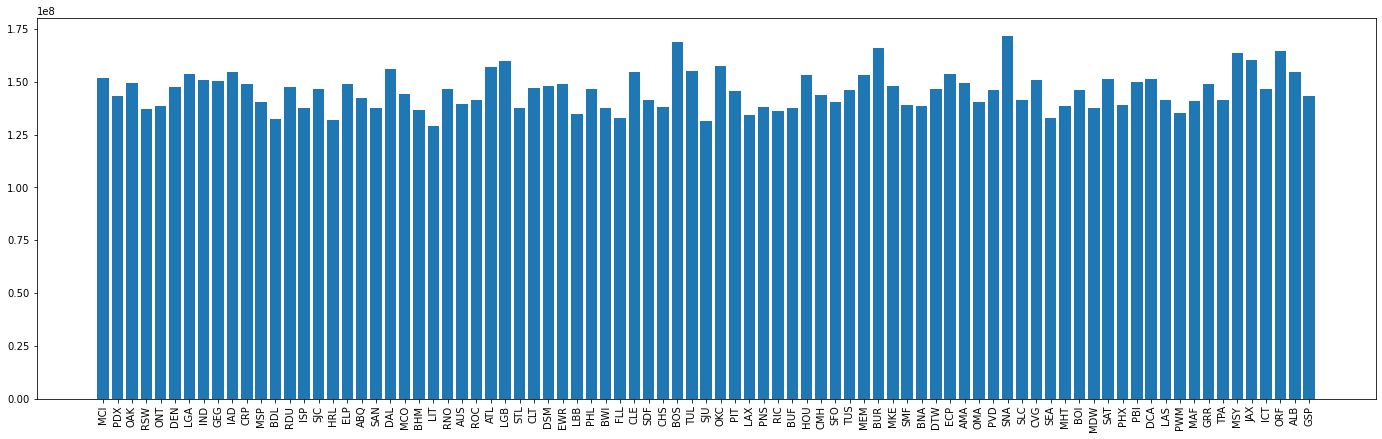

In [55]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, profits_vec)
plt.xticks(rotation=90)
plt.show()

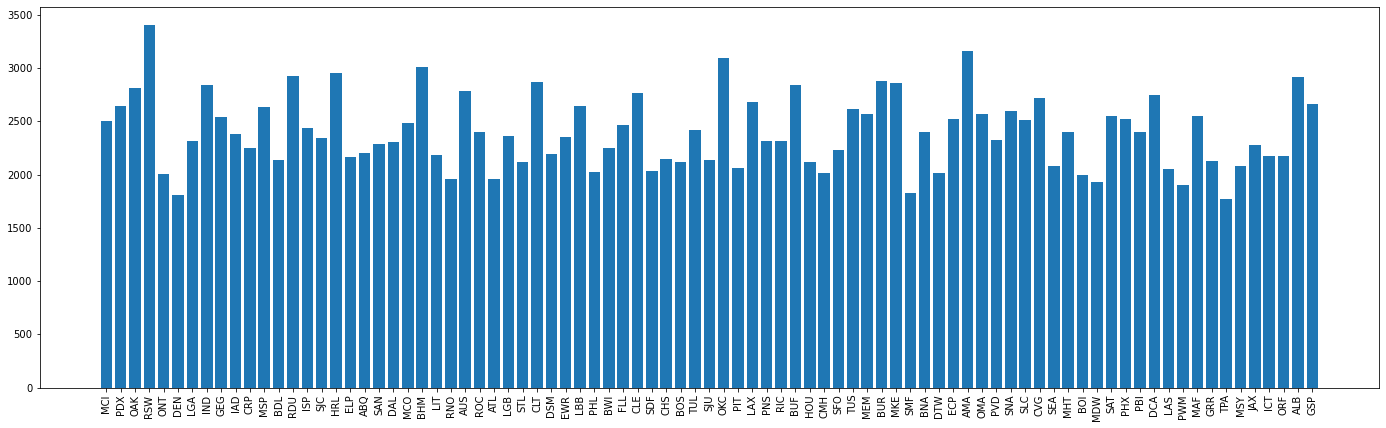

In [57]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, dept_delay_vec)
plt.xticks(rotation=90)
plt.show()

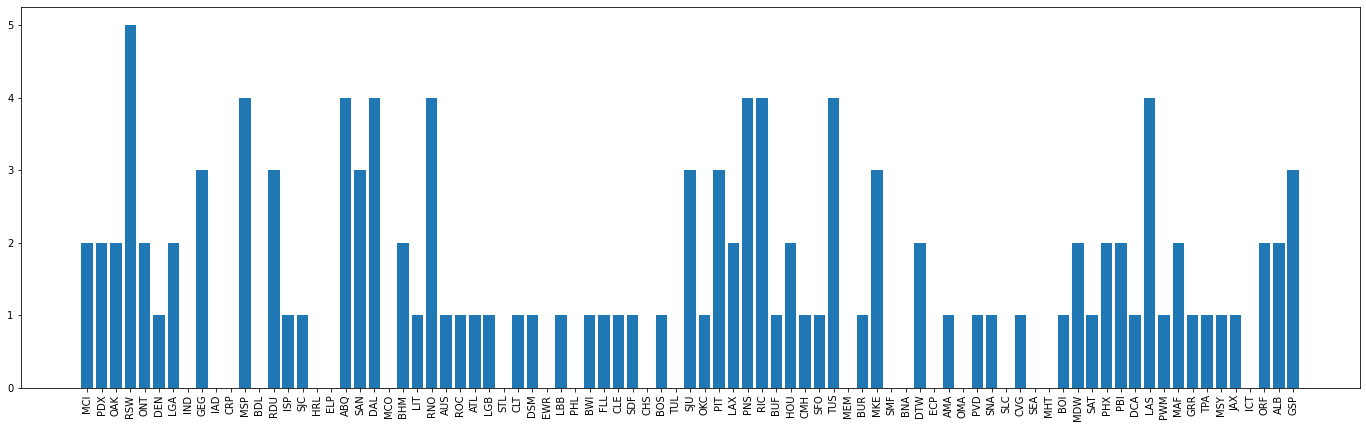

In [58]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, cancellations_vec)
plt.xticks(rotation=90)
plt.show()

### Generate Path Visualizations

In [31]:
# import airports data code log
import airportsdata
airports = airportsdata.load('IATA')  # key is the IATA location code
print(airports['JFK'])

{'icao': 'KJFK', 'iata': 'JFK', 'name': 'John F Kennedy International Airport', 'city': 'New York', 'subd': 'New York', 'country': 'US', 'elevation': 13.0, 'lat': 40.6399277777778, 'lon': -73.7786925, 'tz': 'America/New_York', 'lid': 'JFK'}


In [38]:
import folium 

# Define the coordinates for each airport
ewr_coords = [airports['EWR']['lat'], airports['EWR']['lon']]
lax_coords = [airports['LAX']['lat'], airports['LAX']['lon']]
mdw_coords = [airports['MDW']['lat'], airports['MDW']['lon']]
phx_coords = [airports['PHX']['lat'], airports['PHX']['lon']]

# Create a map centered on the first airport
map = folium.Map(location=ewr_coords, zoom_start=3, width=700, height=400)

# Add markers for each airport on the route
folium.Marker(location=ewr_coords, popup="EWR").add_to(map)
folium.Marker(location=mdw_coords, popup="MDW").add_to(map)
folium.Marker(location=phx_coords, popup="PHX").add_to(map)
folium.Marker(location=lax_coords, popup="LAX").add_to(map)

# Connect the markers with a polyline
folium.PolyLine(locations=[ewr_coords, mdw_coords, phx_coords,lax_coords], color='red').add_to(map)
map

In [77]:
def visualize_route(G, start_node, N):
    # define a function to simulate a flight traversal for a sinl
    current_node = start_node

    # extract each attribute of the graph as a dict
    profits=nx.get_edge_attributes(G,'net_profit')
    cancel_prob=nx.get_edge_attributes(G,'CANCELLED')
    citypair=nx.get_edge_attributes(G,'citypair')

    total_profits = []
    total_dept_delays = []
    total_arrival_delays = []
    number_of_cancel = 0

    number_of_legs = []

    visited_airports = [start_node]

    for i in range(N):
        # get all adjacent nodes of the current node
        adj_nodes = list(G.neighbors(current_node))
        # randomly select a flight route given the transition probability 
        demand=nx.get_edge_attributes(p_2_p_Graph,'Demand_prop')
        node_demand_probs = [demand[i] for i in list(p_2_p_Graph.edges(current_node))] 
        node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
        next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
        next_node = adj_nodes[next_ind[0]]

        # calculate the profit of the flight route
        profit = profits[(current_node,next_node)]
        total_profits.append(profit)
        # extract 
        # randomly simulate a delay time from the distribution
        code = citypair[(current_node,next_node)]
        try:
            dept_delay_time = random_samples(code, 'DEP_DELAY_NEW')[0]
            arr_delay_time = random_samples(code, 'ARR_DELAY_NEW')[0]
        except:
            dept_delay_time = 0
            arr_delay_time = 0

        total_dept_delays.append(dept_delay_time)
        total_arrival_delays.append(arr_delay_time)

        cancel_p = cancel_prob[(current_node,next_node)]
        # returns a bernoulli 0 or 1 value
        r = bernoulli.rvs(p=cancel_p, size=1)[0]
        number_of_cancel += r
        # move to the next node
        current_node = next_node
        visited_airports.append(next_node)
        number_of_legs.append(i+1)
        # return the profit generated by the flight traversal

        # visualize the route
    # store the long and lat coordinates
    locations_stored = []
    for j in visited_airports:
        coords = [airports[j]['lat'], airports[j]['lon']]
        locations_stored.append(coords)
    print('Cancelled Flights on this route:', number_of_cancel)
    print('Total Departure Delay Time on this route:', sum(total_dept_delays))
    print('Total Arrival Delay Time on this route:', sum(total_arrival_delays))
    print('Profit generated', sum(total_profits))
    print('Avg Profit on each leg', np.mean(total_profits))
    print('Path:', visited_airports)

    map = folium.Map(location=locations_stored[0], zoom_start=3, width=700, height=400)
    # Add markers for each airport on the route
    folium.Marker(location=locations_stored[0], popup=visited_airports[0]).add_to(map)
    folium.Marker(location=locations_stored[-1], popup=visited_airports[-1]).add_to(map)
    folium.PolyLine(locations=locations_stored, color='red').add_to(map)
    #display map
    return map 

In [82]:
visualize_route(p_2_p_Graph, 'MDW', 5)

Cancelled Flights on this route: 0
Total Departure Delay Time on this route: 50.732341653835455
Total Arrival Delay Time on this route: 197.3891583615041
Profit generated 9858794.27051229
Avg Profit on each leg 1971758.854102458
Path: ['MDW', 'LAS', 'MKE', 'PHX', 'LAS', 'LIT']


### Interesting Findings